input_size: 29 | num_classes: 5
Dist train: Counter({np.int64(0): 329, np.int64(1): 212, np.int64(2): 87, np.int64(3): 86, np.int64(4): 22})
Dist test : Counter({np.int64(0): 82, np.int64(1): 53, np.int64(2): 22, np.int64(3): 21, np.int64(4): 6})
class_weight: {0: 0.44741642475128174, 1: 0.6943396329879761, 2: 1.6919540166854858, 3: 1.7116279602050781, 4: 6.690908908843994}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,421 (48.52 KB)

 Trainable params: 12,421 (48.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
10/10 - 1s - 85ms/step - accuracy: 0.2816 - loss: 1.5877 - val_accuracy: 0.5315 - val_loss: 1.4056 - learning_rate: 1.0000e-03
Epoch 2/300
10/10 - 0s - 3ms/step - accuracy: 0.4880 - loss: 1.4587 - val_accuracy: 0.5405 - val_loss: 1.2835 - learning_rate: 1.0000e-03
Epoch 3/300
10/10 - 0s - 3ms/step - accuracy: 0.5264 - loss: 1.3621 - val_accuracy: 0.5405 - val_loss: 1.1879 - learning_rate: 1.0000e-03
Epoch 4/300
10/10 - 0s - 3ms/step - accuracy: 0.5568 - loss: 1.2686 - val_accuracy: 0.5856 - val_loss: 1.1166 - learning_rate: 1.0000e-03
Epoch 5/300
10/10 - 0s - 3ms/step - accuracy: 0.5808 - loss: 1.2199 - val_accuracy: 0.6396 - val_loss: 1.0898 - learning_rate: 1.0000e-03
Epoch 6/300
10/10 - 0s - 4ms/step - accuracy: 0.5680 - loss: 1.1910 - val_accuracy: 0.5676 - val_loss: 1.0909 - learning_rate: 1.0000e-03
Epoch 7/300
10/10 - 0s - 3ms/step - accuracy: 0.5984 - loss: 1.1471 - val_accuracy: 0.5766 - val_loss: 1.0785 - learning_rate: 1.0000e-03
Epoch 8/300
10/10 - 0s - 3ms/step

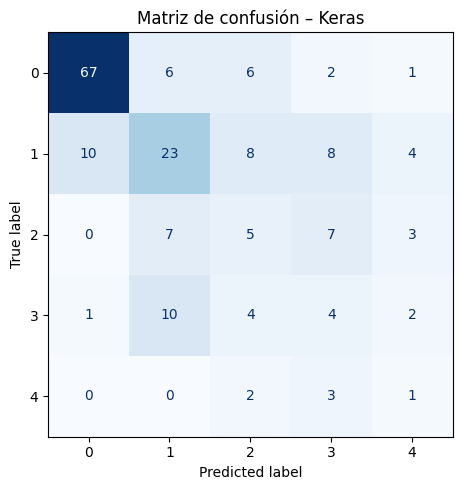

In [40]:
import os
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# (Opcional) estabilidad/hilos:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

# ========= CARGA =========
df = pd.read_csv("heart_disease_uci.csv")
target_col = "num"
drop_cols  = ["id"]

X_df = df.drop(columns=[target_col] + [c for c in drop_cols if c in df.columns])
y    = df[target_col].astype(int).to_numpy()

# ========= PREPRO =========
num_selector = selector(dtype_include=np.number)
cat_selector = selector(dtype_exclude=np.number)

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_selector),
        ("cat", cat_pipe, cat_selector),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

pre.fit(X_train_df)
X_train = pre.transform(X_train_df).astype("float32")
X_test  = pre.transform(X_test_df).astype("float32")

input_size  = X_train.shape[1]
classes     = np.unique(y_train)
num_classes = classes.size
print("input_size:", input_size, "| num_classes:", num_classes)
print("Dist train:", Counter(y_train))
print("Dist test :", Counter(y_test))

# ========= CLASS WEIGHTS =========
cls, cnt = np.unique(y_train, return_counts=True)
weights = (cnt.sum() / (len(cls) * cnt)).astype(np.float32)
class_weight = {int(c): float(w) for c, w in zip(cls, weights)}
print("class_weight:", class_weight)

# ========= MODELO TF =========
def build_model(input_dim, num_classes):
    return keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dense(num_classes, activation="softmax"),
    ])

model = build_model(input_size, num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
]

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=300,
    batch_size=64,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

# ========= EVALUACIÓN =========
probs  = model.predict(X_test, batch_size=256, verbose=0)
y_pred = probs.argmax(axis=1)

print("\n== Reporte Keras ==")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, values_format='d', cmap='Blues', colorbar=False)
plt.title("Matriz de confusión – Keras")
plt.tight_layout()
plt.show()

# (Opcional) guardar
# model.save("heart_disease_tf.keras")
# Guarda también el preprocesador con joblib para inferencia
# import joblib; joblib.dump(pre, "preprocessor.joblib")

In [46]:
import numpy as np, pandas as pd, warnings, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Opcionales (si instalados)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    HAS_CAT = False

# === Carga ===
# df = pd.read_csv("heart_disease_uci.csv")
# #df = df.assign(num_trans=df['num'].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 2}).astype('category'))
# df = df.loc[df['num'] != 4]
# y = df["num"].astype(int).to_numpy()
# X = df.drop(columns=[c for c in ["num","id","dataset", 'num_trans'] if c in df.columns])

# === Carga ===
df = pd.read_csv("heart_disease_uci.csv")

# Eliminar clase 4 por completo
#df = df[df["num"] != 4].copy()

# Nuevo target: 0 = sano, 1 = cualquier enfermedad
#df = df.assign(num_trans=(df['num'] > 0).astype(int))

y = df["num"].astype(int).to_numpy()
X = df.drop(columns=[c for c in ["num","id","dataset"] if c in df.columns])

print("Distribución global después del filtrado:", Counter(y))

# Selectores
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

# Preprocesador
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_sel),
    ("cat", cat_pipe, cat_sel)
], remainder="drop", verbose_feature_names_out=False)

# Métricas
scorers = {
    "acc": "accuracy",
    "bal_acc": make_scorer(balanced_accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
    "weighted_f1": make_scorer(f1_score, average="weighted"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_model(name, clf):
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1, return_train_score=False)
    m = {k: (np.mean(v), np.std(v)) for k,v in scores.items() if k.startswith("test_")}
    print(f"\n=== {name} ===")
    for k,(mu,sd) in m.items():
        print(f"{k[5:]:>10s}: {mu:.4f} ± {sd:.4f}")
    return m

print("Distribución global:", Counter(y))

# Modelos base
_ = eval_model("LogReg (l2)", LogisticRegression(max_iter=2000, class_weight="balanced"))
_ = eval_model("RandomForest", RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2, class_weight="balanced_subsample", random_state=42))
_ = eval_model("GradientBoosting", GradientBoostingClassifier(random_state=42))

if HAS_XGB:
    _ = eval_model("XGBoost", XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.8,
        reg_lambda=1.0, objective="multi:softprob", num_class=len(np.unique(y)),
        tree_method="hist", eval_metric="mlogloss", random_state=42))

if HAS_CAT:
    # CatBoost maneja categóricas nativas, pero aquí ya ohe; lo dejamos así por simplicidad
    _ = eval_model("CatBoost", CatBoostClassifier(
        depth=6, learning_rate=0.1, n_estimators=800, loss_function="MultiClass", verbose=False,
        random_state=42, auto_class_weights="Balanced"))

Distribución global después del filtrado: Counter({np.int64(0): 411, np.int64(1): 265, np.int64(2): 109, np.int64(3): 107, np.int64(4): 28})
Distribución global: Counter({np.int64(0): 411, np.int64(1): 265, np.int64(2): 109, np.int64(3): 107, np.int64(4): 28})

=== LogReg (l2) ===
       acc: 0.5293 ± 0.0249
   bal_acc: 0.3915 ± 0.0327
  macro_f1: 0.3735 ± 0.0241
weighted_f1: 0.5479 ± 0.0207

=== RandomForest ===
       acc: 0.5674 ± 0.0196
   bal_acc: 0.3808 ± 0.0607
  macro_f1: 0.3802 ± 0.0654
weighted_f1: 0.5610 ± 0.0219

=== GradientBoosting ===
       acc: 0.5761 ± 0.0203
   bal_acc: 0.3507 ± 0.0183
  macro_f1: 0.3472 ± 0.0214
weighted_f1: 0.5560 ± 0.0183

=== XGBoost ===
       acc: 0.5728 ± 0.0184
   bal_acc: 0.3772 ± 0.0322
  macro_f1: 0.3810 ± 0.0401
weighted_f1: 0.5592 ± 0.0196

=== CatBoost ===
       acc: 0.5533 ± 0.0286
   bal_acc: 0.3749 ± 0.0217
  macro_f1: 0.3757 ± 0.0223
weighted_f1: 0.5524 ± 0.0227


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote = SMOTE(random_state=42, k_neighbors=3)
rf = RandomForestClassifier(
    n_estimators=400, min_samples_leaf=2, class_weight=None, random_state=42
)

imb_pipe = ImbPipeline([("pre", pre), ("smote", smote), ("clf", rf)])
scores = cross_validate(imb_pipe, X, y, cv=cv, scoring=scorers, n_jobs=-1)
print("\n=== RandomForest + SMOTE ===")
for k,v in scores.items():
    if k.startswith("test_"):
        print(f"{k[5:]:>10s}: {np.mean(v):.4f} ± {np.std(v):.4f}")


=== RandomForest + SMOTE ===
       acc: 0.7837 ± 0.0274
   bal_acc: 0.5839 ± 0.0628
  macro_f1: 0.5907 ± 0.0646
weighted_f1: 0.7786 ± 0.0298


In [ ]:
# Replantear: binario
y_bin = (y > 0).astype(int)

# Reusa el mismo preprocesador
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

scorers = {
    "acc": "accuracy",
    "bal_acc": make_scorer(balanced_accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([("pre", pre), 
                 ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
scores = cross_validate(pipe, X, y_bin, cv=cv, scoring=scorers, n_jobs=-1)

for k,v in scores.items():
    if k.startswith("test_"):
        print(k[5:], np.mean(v))

acc 0.8217391304347826
bal_acc 0.8211855675896192
macro_f1 0.820129374237634


In [ ]:
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,num_trans
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2,1
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# --- Reagrupación personalizada ---
positive_classes = {1, 2, 4}
y_grouped = np.where(np.isin(y, list(positive_classes)), 1, 0)

# --- Scorers ---
scorers = {
    "acc": "accuracy",
    "bal_acc": make_scorer(balanced_accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Diccionario de modelos ---
models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(class_weight="balanced"),
    "KNN": KNeighborsClassifier(),
}

# --- Evaluación ---
results = {}
for name, clf in models.items():
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    scores = cross_validate(pipe, X, y_grouped, cv=cv, scoring=scorers, n_jobs=-1)
    results[name] = {k[5:]: np.mean(v) for k, v in scores.items() if k.startswith("test_")}

# --- Convertir a DataFrame bonito ---
df_results = pd.DataFrame(results).T
print(df_results)

                       acc   bal_acc  macro_f1
LogReg            0.821739  0.821186  0.820129
RandomForest      0.828261  0.824452  0.825509
GradientBoosting  0.817391  0.812106  0.813785
SVM               0.832609  0.830745  0.830718
KNN               0.826087  0.821784  0.823175


In [ ]:
df['num_trans'].nunique()

3

In [ ]:
df['num'].nunique()

5

In [ ]:
df['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Distribución global después del filtrado: Counter({np.int64(1): 481, np.int64(0): 411})
